# Imports

In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import csv

from commpy.filters import rrcosfilter
from scipy.signal import convolve

# Waveform Configuration

In [2]:
# Settings

number_symbols = 1137
mixing_matrix = np.array([[0.7, 0.3], [0.3, 0.7]])
carrier_freq = 1e9
symbol_freq = 200e6

filter_rolloff = 0.4
filter_factor = 4 # Multiple of samples per symbol for duration in rrcos filter

# AWG Constants

In [3]:
# Constants
MIN_FREQ = 82.24e9
MAX_FREQ = 92e9
SAMPLE_DIVISOR = 128 # Number of samples must be multiple of this
MAX_SAMPLES = 2**19 # I think? 

# Initial Setup

In [4]:
# Load bit data
with open("data_bits", "rb") as infile:
    data = pickle.load(infile)
    
bits1 = data[0][:number_symbols]
bits2 = data[1][:number_symbols]

In [5]:
# Derived constants
symbol_period = 1/symbol_freq
duration = number_symbols * symbol_period
ideal_samples = duration*MAX_FREQ
rounded_samples = (ideal_samples // SAMPLE_DIVISOR) * SAMPLE_DIVISOR
rounded_freq = rounded_samples // duration

samples = int(rounded_samples)
freq = rounded_freq

samples_per_symbol = samples // number_symbols # Approximate - used for filtering

offset_freq = carrier_freq/int(carrier_freq*duration)


In [6]:
# Generate list of sample times - at max samples, max_freq
times = np.array(list(range(0, samples)))*1/freq


# Filter Generation

In [7]:
# Create root raised cosine filter
rrcos_times, rrcos_response = rrcosfilter(2*filter_factor*samples_per_symbol,
                                            filter_rolloff,
                                            symbol_period,
                                            freq) #CHANGE - should be freq

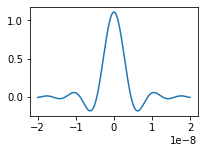

In [8]:
plt.figure(figsize=[3,2])
plt.plot(rrcos_times, rrcos_response)

In [9]:
# Create sinc filter
def sinc_filter(points): # Points should be in [0, 1) refering to location in symbol
    adjusted_points = (points-0.5)*filter_factor*2
    return np.sinc(adjusted_points)

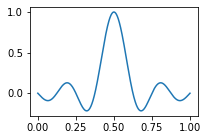

In [10]:
points = np.linspace(0, 1, 1001)
plt.figure(figsize=[3,2])
plt.plot(points, sinc_filter(points))

# Waveform Generation

In [11]:
def modulate(bits, sign):
    """ Creates BPSK waveform from the given bitstream"""
    if sign not in [-1, 1]:
        raise Exception("Sign must be -1 or 1")
    
    # STEP 1 - Digital signal
    signal1 = bits*2 - 1
    
    # STEP 2 - Sinc-ed base signal - no bits
    symbol_positions = (times%symbol_period)/symbol_period # Proportional position in symbol for each time
    signal2 = sinc_filter(symbol_positions)
    
    # STEP 3 - bit signal with correct timing
    signal3 = [signal1[int(i)] for i in times//symbol_period]
    
    # STEP 4 - Modulate sinc signal with bit signal
    signal4 = signal2 * signal3
    
    # STEP 5 - Apply rrcos filter
    extended_sinc = np.hstack([signal4, signal4, signal4]) # Pad to either side
    padded_rrcos = convolve(extended_sinc, rrcos_response)
    from_index = samples + filter_factor*samples_per_symbol
    to_index = -from_index
    signal5 = padded_rrcos[from_index:to_index+1]
    
    # STEP 6 - Mix with carrier frequency
    carrier = np.cos(2*np.pi*(carrier_freq + sign*offset_freq)*times)
    signal6 = np.real(signal5*carrier)
    
    # STEP 7 - Normalize
    signal7 = signal6/np.max(signal6)
    
    return signal7
    

In [12]:
signal1 = modulate(bits1, -1)
signal2 = modulate(bits2, 1)

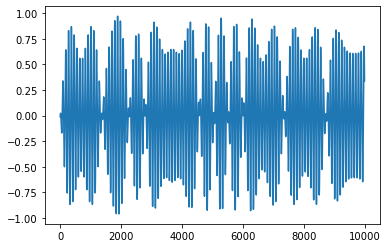

In [13]:
plt.plot(signal1[:10000])

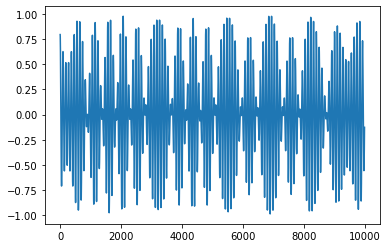

In [14]:
plt.plot(signal2[:10000])

# Waveform Mixing

In [15]:
mixed_signals = mixing_matrix@[signal1, signal2]
mixed1 = mixed_signals[0]
mixed2 = mixed_signals[1]
mixed1 = mixed1/np.max(mixed1)
mixed2 = mixed2/np.max(mixed2)

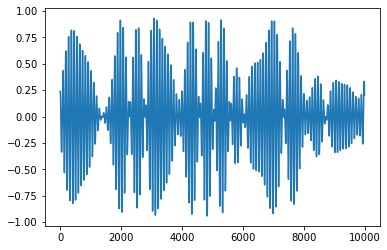

In [16]:
plt.plot(mixed1[:10000])

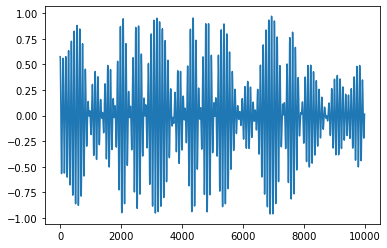

In [17]:
plt.plot(mixed2[:10000])

# Trigger Signal

In [18]:
trigger = np.zeros(samples)
trigger[0:512] = 1

# Write to File

In [19]:
with open('wfm.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['SampleRate={:.0f}'.format(freq)])
    writer.writerow(['SetConfig=true'])
    writer.writerow(['Y1','Y2','Y3','Y4'])
    for i in range(samples):
        writer.writerow(['{:.6f}'.format(mixed1[i]),'{:.6f}'.format(trigger[i]),'{:.6f}'.format(trigger[i]),'{:.6f}'.format(-mixed2[i])])
